In [107]:
import numpy as np
import pandas as pd
import json, os, sys
import matplotlib.pyplot as plt

In [108]:
tapas_results = pd.read_json('results/tapas_small_8sept.json')

(array([1.65252e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 3.00000e+00, 0.00000e+00, 0.00000e+00, 7.00000e+01]),
 array([-1.00000e+00,  3.03440e+03,  6.06980e+03,  9.10520e+03,
         1.21406e+04,  1.51760e+04,  1.82114e+04,  2.12468e+04,
         2.42822e+04,  2.73176e+04,  3.03530e+04]),
 <BarContainer object of 10 artists>)

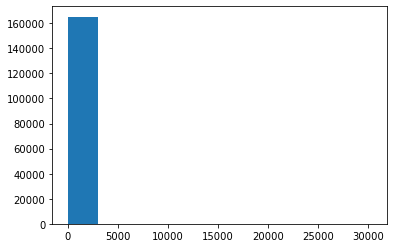

In [109]:
plt.hist(tapas_results.best_prediction.values)

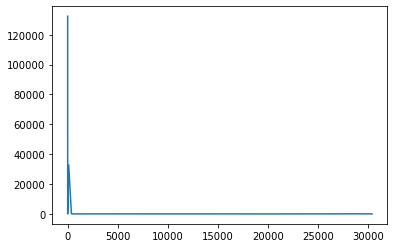

In [16]:
vals, counts = np.unique(tapas_results.best_prediction.values, return_counts= True)
plt.plot(vals, counts)

In [17]:
vals

array([   -1,     1,   103,   373,   585,   599,   828,  1021,  1048,
        1062,  2563, 20070, 29345, 30353])

In [18]:
counts

array([132356,      9,  32727,    103,      3,      1,      1,      4,
            6,      5,     37,      3,     69,      1])

In [12]:
tapas_results.cloze_id.nunique()

5650

In [13]:
tapas_results.loc[tapas_results.best_prediction == tapas_results.answer]

,cloze_text,best_prediction,prediction,confidences,answer,cloze_id,bulletin,dataset_path,sheet_name,sheet_name_counter


In [106]:
tapas_results

NameError: name 'tapas_results' is not defined

# testing

In [17]:
import torch

In [7]:
from transformers import TapasTokenizer, TapasForMaskedLM

tokenizer = TapasTokenizer.from_pretrained('google/tapas-base-masklm')
model = TapasForMaskedLM.from_pretrained('google/tapas-base-masklm')

Downloading: 100%|██████████| 232k/232k [00:00<00:00, 506kB/s]
Downloading: 100%|██████████| 558/558 [00:00<00:00, 213kB/s]
Downloading: 100%|██████████| 1.51k/1.51k [00:00<00:00, 441kB/s]
Downloading: 100%|██████████| 443M/443M [06:16<00:00, 1.18MB/s]


In [24]:
data = {
    'student': ['Savvas', 'Pavlos'],
    'age': ['25', '19'] 
    }

table = pd.DataFrame(data)

queries = ['Savvas is [MASK] years old', '[MASK] is 19 years old']

In [25]:
inputs = tokenizer(
    table = table.astype(str), queries = queries,
    return_tensors = 'pt', padding = True)

In [26]:
outputs = model(**inputs)

In [27]:
masked_index = torch.nonzero(
    inputs.input_ids.squeeze() == tokenizer.mask_token_id,
    as_tuple=False)
logits = outputs.logits[0, 5, :]
probs = logits.softmax(dim=0)
values, predictions = probs.topk(5)
print(predictions)

logits = outputs.logits[1, 1, :]
probs = logits.softmax(dim=0)
values, predictions = probs.topk(5)
print(predictions)

tensor([2423, 2539, 2484, 2656, 2676])
tensor([2040, 2016, 2002, 2009, 2082])


In [34]:
tokenizer.decode(2082)

's c h o o l'

In [35]:
tokenizer = TapasTokenizer.from_pretrained("google/tapas-large-masklm")
model = TapasForMaskedLM.from_pretrained("google/tapas-large-masklm")

Downloading: 100%|██████████| 232k/232k [00:08<00:00, 25.8kB/s]
Downloading: 100%|██████████| 558/558 [00:00<00:00, 121kB/s]
Downloading: 100%|██████████| 1.52k/1.52k [00:00<00:00, 443kB/s]
Downloading: 100%|██████████| 1.35G/1.35G [21:34<00:00, 1.04MB/s]


NameError: name 'query' is not defined

In [50]:

# data = {'Actors': ["Brad Pitt", "Leonardo Di Caprio", "George Clooney"],
#         'Age': ["56", "45", "59"],
#         'Number of movies': ["87", "53", "69"]
# }

# queries = ['Brad [MASK] played in 87 movies.',
#            'George Clooney is [MASK] years old.']

# query = ['Brad [MASK] played in 87 movies.']

data = { 
    'person': ['Savvas', 'Pavlos', 'Brad'],
    'age': ['25', '19', '59'],
    'occupation': ['badass gangster', 'rapper', 'actor']
    }

table = pd.DataFrame(data)

queries = [
        'Savvas is [MASK] years old', 
        '[MASK] is 19 years old', 
        "Savvas's occupation is a [MASK]",
        'Savvas is [MASK] years old'
]


query = queries[2]

table = pd.DataFrame.from_dict(data)


# prepare inputs
inputs = tokenizer(table=table, queries=query, padding="max_length", return_tensors="pt")

# forward pass
outputs = model(**inputs)

# return top 5 values and predictions
masked_index = torch.nonzero(inputs.input_ids.squeeze() == tokenizer.mask_token_id, as_tuple=False)
logits = outputs.logits[0, masked_index.item(), :]
probs = logits.softmax(dim=0)
values, predictions = probs.topk(5)

for value, pred in zip(values, predictions):
  print(f"{query} -> {tokenizer.decode([pred])} with confidence {value}")

Savvas's occupation is a [MASK] -> gangster with confidence 0.28790542483329773
Savvas's occupation is a [MASK] -> rapper with confidence 0.031446825712919235
Savvas's occupation is a [MASK] -> bad with confidence 0.026088278740644455
Savvas's occupation is a [MASK] -> friend with confidence 0.012044738978147507
Savvas's occupation is a [MASK] -> drug with confidence 0.009916343726217747


In [52]:
from helpers.configs import CLOZE_MASKS

from helpers.cloze_generation import generate_clozes_from_point, named_entity_answer_generator as ne_answer_generator, noun_phrase_answer_generator as np_answer_generator

from helpers.table_processing import preprocess_table, read_process_table, find_relevant_column_header, find_relevant_content
from helpers.t5_language_model import summarise_t5_results


# df = pd.read_pickle('pickles/dataset_20210625_184837.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210807_165700.json')

df = pd.read_pickle('pickles/collection_20210624_194932.pkl')
# clozes_df = pd.read_json('pickles/clozes_20210824.json')
clozes_df = pd.read_json('pickles/clozes_with_false_20210825.json') #contains negs

clozes_df['answer_type_agg'] = clozes_df['answer_type'].apply(
    lambda x: CLOZE_MASKS.get(x))

In [63]:
import spacy
nlp = spacy.load('en_core_web_trf')

from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer()
vectorizer = TfidfVectorizer(ngram_range=(2,3))

import nltk
# nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

In [65]:
cloze = 'In [MASK], approximate gross value added at basic prices (aGVA) of the UK non-financial business economy was estimated to be £1,313.9 billion; an increase of £42.8 billion (3.4%) compared with 2018.'

In [86]:
path = 'datasets/' + clozes_df.iloc[0]['data'][1].replace('/', '_')[1:] + '.xls'
excel = pd.ExcelFile(path)
sheet_names = excel.sheet_names
table = excel.parse(sheet_names[2])

In [87]:
processed = preprocess_table(table)
relevant_idx = find_relevant_column_header(cloze, preprocess_table(table), vectorizer)

In [89]:
processed.iloc[
    :, [0, 1, 2, 3] + relevant_idx.tolist()].iloc[:10]

,Standard Industrial Classification (Revised 2007) Section,"Agriculture, Fishing, Production,",Country and Region,Year,Approximate gross value added at basic prices (aGVA)
0,A-S (Part) 1,"Agriculture, Fishing, Production,",North East,2008,28037
1,A-S (Part) 1,"Construction, Distribution and",North East,2009,25178
2,A-S (Part) 1,Non-Financial Service Industries,North East,2010,26081
3,A-S (Part) 1,Non-Financial Service Industries,North East,2011,26812
4,A-S (Part) 1,Non-Financial Service Industries,North East,2012,28755
5,A-S (Part) 1,Non-Financial Service Industries,North East,2013,27919
6,A-S (Part) 1,Non-Financial Service Industries,North East,2014,32138
7,A-S (Part) 1,Non-Financial Service Industries,North East,2015,32412
8,A-S (Part) 1,Non-Financial Service Industries,North East,2016,32347
9,A-S (Part) 1,Non-Financial Service Industries,North East,2017,32914


In [104]:
query = 'In 2009, approximate gross value added at basic prices (aGVA) of the construction and [MASK] industries was estimated to be 25178'
table = processed.iloc[
    :, [0, 1, 2, 3] + relevant_idx.tolist()].iloc[:10]

In [105]:
# prepare inputs
inputs = tokenizer(table=table, queries=query, padding="max_length", return_tensors="pt")

# forward pass
outputs = model(**inputs)

# return top 5 values and predictions
masked_index = torch.nonzero(inputs.input_ids.squeeze() == tokenizer.mask_token_id, as_tuple=False)
logits = outputs.logits[0, masked_index.item(), :]
probs = logits.softmax(dim=0)
values, predictions = probs.topk(5)

for value, pred in zip(values, predictions):
  print(f"{query} -> {tokenizer.decode([pred])} with confidence {value}")

In 2009, approximate gross value added at basic prices (aGVA) of the construction and [MASK] industries was estimated to be 25178 -> distribution with confidence 0.7610072493553162
In 2009, approximate gross value added at basic prices (aGVA) of the construction and [MASK] industries was estimated to be 25178 -> shipping with confidence 0.02022368274629116
In 2009, approximate gross value added at basic prices (aGVA) of the construction and [MASK] industries was estimated to be 25178 -> production with confidence 0.011187724769115448
In 2009, approximate gross value added at basic prices (aGVA) of the construction and [MASK] industries was estimated to be 25178 -> agricultural with confidence 0.010608246549963951
In 2009, approximate gross value added at basic prices (aGVA) of the construction and [MASK] industries was estimated to be 25178 -> wholesale with confidence 0.008337625302374363
